# SEGMENTATION

In [ ]:
!pip install kaggle

In [1]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print("User uploaded file '{name}' with length {length} bytes".format(
      name=fn,length=len(uploaded[fn])
  ))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file 'kaggle.json' with length 71 bytes


In [2]:
!kaggle competitions list

ref                                                                                deadline             category                reward  teamCount  userHasEntered  
---------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-2      2025-04-01 23:59:00  Featured         2,117,152 Usd        188           False  
https://www.kaggle.com/competitions/arc-prize-2024                                 2024-11-10 23:59:00  Featured         1,100,000 Usd       1291           False  
https://www.kaggle.com/competitions/gemma-language-tuning                          2025-01-15 00:59:00  Analytics          150,000 Usd          0           False  
https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting  2025-01-13 23:59:00  Featured           120,000 Usd        593           False  
https://www.kagg

In [3]:
!kaggle datasets download "tschandl/isic2018-challenge-task1-data-segmentation"

Dataset URL: https://www.kaggle.com/datasets/tschandl/isic2018-challenge-task1-data-segmentation
License(s): CC0-1.0
100% 12.9G/12.9G [11:27<00:00, 20.9MB/s]
100% 12.9G/12.9G [11:27<00:00, 20.1MB/s]


In [4]:
!unzip isic2018-challenge-task1-data-segmentation.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000345.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000346.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000348.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000349.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000350.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000351.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000352.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000353.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000354.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000355.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000357.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000358.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000359.jpg  
  inflating: ISIC2018_Task1-2_Training_Input/ISIC_0000360.jpg  
  inflating: ISIC2018_Task

In [5]:
import os
import random
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tdfs
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D ,MaxPooling2D ,UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout ,Activation


In [6]:
import os
import tensorflow as tf


train_image_path="/content/ISIC2018_Task1-2_Training_Input"
train_mask_path="/content/ISIC2018_Task1_Training_GroundTruth"

test_image_path="/content/ISIC2018_Task1-2_Test_Input"


def normalize(input_image,input_mask=None):
  input_image=tf.cast(input_image,tf.float32)/255.0
  if input_mask is not None:
    input_mask=tf.cast(input_mask,tf.float32)/255.0
  return input_image,input_mask

def load_train_image(image_path,mask_path):
  input_image=tf.io.read_file(image_path)
  input_image=tf.image.decode_jpeg(input_image,channels=3)
  input_image=tf.image.resize(input_image,(128,128))

  input_mask=tf.io.read_file(mask_path)
  input_mask=tf.image.decode_png(input_mask,channels=1)
  input_mask=tf.image.resize(input_mask,(128,128),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  input_image,input_mask=normalize(input_image,input_mask)
  return input_image, input_mask

def load_test_image(image_path):
  input_image=tf.io.read_file(image_path)
  input_image=tf.image.decode_jpeg(input_image,channels=3)
  input_image=tf.image.resize(input_image,(128,128))
  input_image,_=normalize(input_image)
  return input_image

def load_train_data(train_image_repertory,mask_repertory):
  train_images_paths=sorted([os.path.join(train_image_repertory,fname) for fname in os.listdir(train_image_repertory) if fname.lower().endswith(('.png','.jpg','.jpeg'))])
  print("train_image_paths :",len(train_images_paths))
  masks_paths=sorted([os.path.join(mask_repertory,fname) for fname in os.listdir(mask_repertory) if fname.lower().endswith(('.png','.jpg','.jpeg'))])
  print("mask_paths :",len(masks_paths))
  assert len(train_images_paths)==len(masks_paths) ,'Number of images and mask should be the same .'
  dataset=tf.data.Dataset.from_tensor_slices((train_images_paths,masks_paths))
  dataset=dataset.map(load_train_image,num_parallel_calls=tf.data.AUTOTUNE)
  return dataset

def load_test_data(test_image_repertory):
  test_images_paths=sorted([os.path.join(test_image_repertory,fname) for fname in os.listdir(test_image_repertory) if fname.lower().endswith(('.png','.jpg','.jpeg'))])
  dataset=tf.data.Dataset.from_tensor_slices(test_images_paths)
  dataset=dataset.map(load_test_image,num_parallel_calls=tf.data.AUTOTUNE)
  return dataset

In [7]:
#Add
import random
import os
train_list =[(img,mask) for img,mask in zip(os.listdir(train_image_path),os.listdir(train_mask_path)) if (img.lower().endswith(('.png','.jpg','.jpeg'))) and (mask.lower().endswith(('.png','.jpg','.jpeg')))]
print(len(train_list))
seed=42
random.seed(seed)
random.shuffle(train_list)
new_train_list=train_list[:int(len(train_list)*0.7)]
valid_list=train_list[int(len(train_list)*0.7):int(len(train_list)*0.85)]
test_list=train_list[int(len(train_list)*0.85):]
print(f"Train Size: {len(new_train_list)} -  Valid Size: {len(valid_list)} - Test Size: {len(test_list)}")

2592
Train Size: 1814 -  Valid Size: 389 - Test Size: 389


In [26]:
print(len(os.listdir(train_image_path)))
print(len(os.listdir(train_mask_path)))

2596
2596


In [ ]:
train_correspondance={}
#for i in range(len(train))

In [32]:
print(new_train_list[0])

('ISIC_0013201.jpg', 'ISIC_0013414_segmentation.png')


In [42]:
#%rm -rf test_data
#%rm -rf test_mask_data

In [8]:
%mkdir training_data
%mkdir mask_training_data
for item in new_train_list:
  #%cp  {{train_image_path/img}} training_data/
  try:
    assert len(os.listdir("/content/training_data"))==len(os.listdir("/content/mask_training_data"))
    %cp {train_image_path}/{item[0]} training_data/
    %cp {train_mask_path}/{item[1]} mask_training_data/
  except:
    print("Anomaly detected")
    break


In [9]:
%mkdir valid_data
%mkdir valid_mask_data
for item in valid_list:
  #%cp  {{train_image_path/img}} training_data/
  %cp {train_image_path}/{item[0]} valid_data/
  %cp {train_mask_path}/{item[1]} valid_mask_data/

In [10]:
%mkdir test_data
%mkdir test_mask_data
for item in test_list:
  #%cp  {{train_image_path/img}} training_data/
  %cp {train_image_path}/{item[0]} test_data/
  %cp {train_mask_path}/{item[1]} test_mask_data/

In [40]:
train_dataset=load_train_data("/content/training_data","/content/mask_training_data")
valid_dataset=load_train_data("/content/valid_data","/content/valid_mask_data")
test_dataset=load_train_data("/content/test_data","/content/test_mask_data")
"""
BATCH_SIZE=64
BUFFER_SIZE = 1000

train_dataset=train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)"""


train_image_paths : 1814
mask_paths : 1814
train_image_paths : 389
mask_paths : 389
train_image_paths : 389
mask_paths : 389


'\nBATCH_SIZE=64\nBUFFER_SIZE = 1000\n \ntrain_dataset=train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)\nvalid_dataset=valid_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)\ntest_dataset=test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)'

In [36]:
len(os.listdir("/content/mask_training_data"))

1814

In [30]:
print(os.listdir("/content/training_data")[0])

ISIC_0007788.jpg


In [12]:
class Augment(tf.keras.layers.Layer):
  def __init__(self,seed=42):
    super().__init__()
    self.augment_inputs=tf.keras.Sequential([tf.keras.layers.RandomFlip(mode="horizontal",seed=seed),
                         tf.keras.layers.RandomRotation(factor=0.1,seed=seed),
                         tf.keras.layers.RandomZoom(height_factor=0.1,seed=seed)
                         ])
    self.augment_labels=tf.keras.Sequential([tf.keras.layers.RandomFlip(mode="horizontal",seed=seed),

                                             tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,seed=seed
                                                                        )])
  def call(self,inputs,labels):
    inputs=self.augment_inputs(inputs)
    labels=self.augment_labels(labels)
    return inputs,labels


In [23]:
def display(display_list):
  plt.figure(figsize=(15,15))
  title=["Input Image","True Mask","Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")

  plt.show()

In [41]:
#train_dataset=load_train_data(train_image_path,train_mask_path)

#test_dataset=load_test_data(test_image_path)

BATCH_SIZE=64
BUFFER_SIZE=1000

augment_layer=Augment()

train_batches=(
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
valid_batch=(
    valid_dataset
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_batches=(
    test_dataset
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

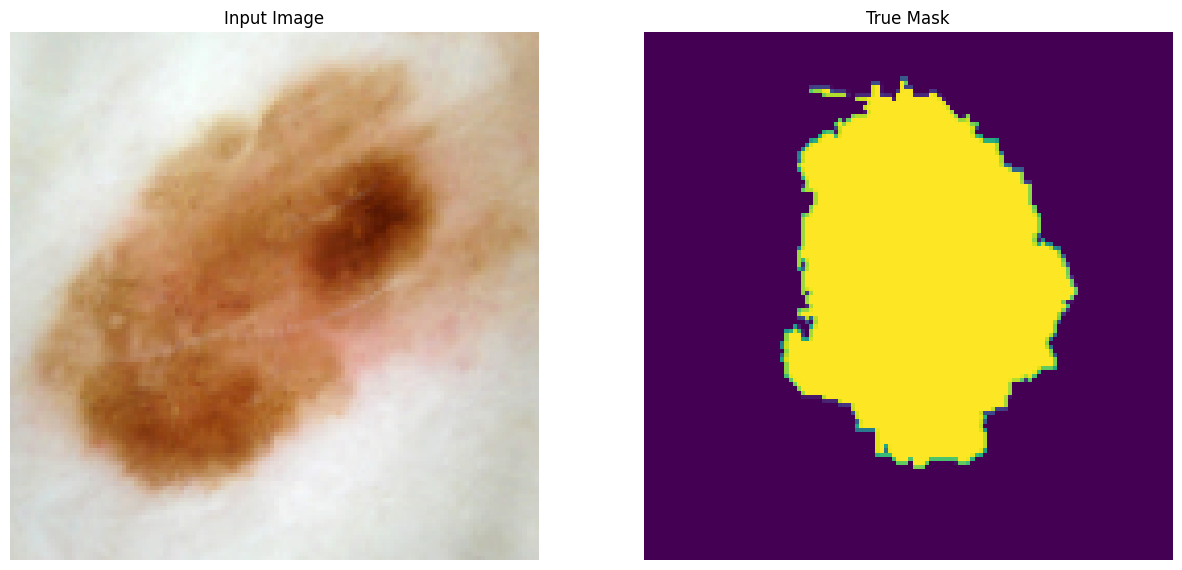

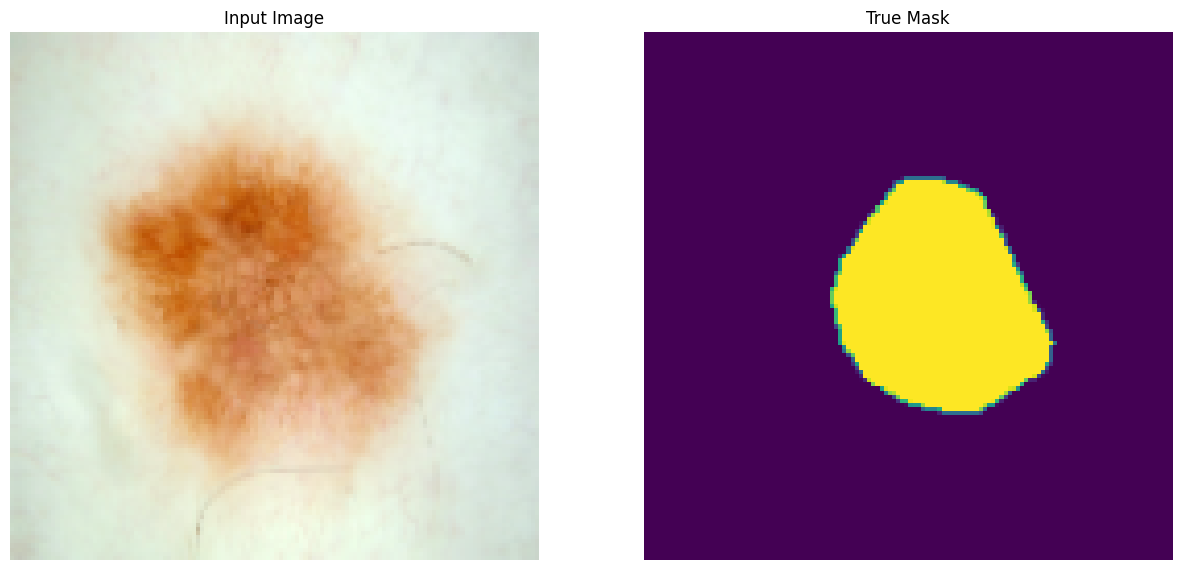

In [26]:
for image,masks in train_batches.take(2):
  sample_image,sample_mask =image[0],masks[0]
  display([sample_image,sample_mask])

In [14]:
base_model=tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

layer_names=[
    'block_1_expand_relu', # 4096
    'block_3_expand_relu', #1024
    'block_6_expand_relu', #256
    'block_13_expand_relu', #64
    'block_16_project',  #16
]

base_model_outputs=[base_model.get_layer(name).output for name in layer_names]

down_stack=tf.keras.Model(inputs=base_model.input,outputs=base_model_outputs)

down_stack.trainable=False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:

def conv_block(x,n_filters):
  x=Conv2D(n_filters,(3,3),padding='same',activation='relu')(x)
  x=Conv2D(n_filters,(3,3),padding='same',activation='relu')(x)
  print("X ...",x)
  return x

def decoder_block(x,p,n_filters):
  x=Conv2DTranspose(n_filters,(2,2),strides=(2,2),padding='same')(x)
  print(f"X :{x} and P :{p}")
  x=concatenate([x,p])
  x=conv_block(x,n_filters)
  return x

#up_stack
class UP_STACK():
  def __init__(self,bridge,p1,p2,p3,p4):
    #bridge=conv_block(p4,n_filters=1024)
    self.u4=decoder_block(bridge,p4,n_filters=512)
    self.u3=decoder_block(self.u4,p3,n_filters=256)
    self. u2=decoder_block(self.u3,p2,n_filters=128)
    self.u1=decoder_block(self.u2,p1,n_filters=64)


inputs=tf.keras.layers.Input(shape=[128,128,3])

skips=down_stack(inputs)
p1=skips[0]
p2=skips[1]
p3=skips[-3]
p4=skips[-2]
bridge=skips[-1]
print(f"P1 :{p1} P2 :{p2} P3 :{p3} P4 :{p4}")
up_stack=UP_STACK(bridge,p1,p2,p3,p4)
#p4=skips[-1]
print("U1 ",up_stack.u1)
outputs=Conv2DTranspose(filters=2,kernel_size=(1,1),strides=(2,2),activation='softmax')(up_stack.u1)

#filters ==> n_classes (numbers of  caracteristics card (=number of classes))
"""
last_layer=tf.keras.layers.Conv2DTranspose(
    filters=output_channels,kernel_size=3,strides=3
)"""
model=Model(inputs=[inputs],outputs=[outputs])

P1 :<KerasTensor shape=(None, 64, 64, 96), dtype=float32, sparse=False, name=keras_tensor_164> P2 :<KerasTensor shape=(None, 32, 32, 144), dtype=float32, sparse=False, name=keras_tensor_165> P3 :<KerasTensor shape=(None, 16, 16, 192), dtype=float32, sparse=False, name=keras_tensor_166> P4 :<KerasTensor shape=(None, 8, 8, 576), dtype=float32, sparse=False, name=keras_tensor_167>
X :<KerasTensor shape=(None, 8, 8, 512), dtype=float32, sparse=False, name=keras_tensor_169> and P :<KerasTensor shape=(None, 8, 8, 576), dtype=float32, sparse=False, name=keras_tensor_167>
X ... <KerasTensor shape=(None, 8, 8, 512), dtype=float32, sparse=False, name=keras_tensor_172>
X :<KerasTensor shape=(None, 16, 16, 256), dtype=float32, sparse=False, name=keras_tensor_173> and P :<KerasTensor shape=(None, 16, 16, 192), dtype=float32, sparse=False, name=keras_tensor_166>
X ... <KerasTensor shape=(None, 16, 16, 256), dtype=float32, sparse=False, name=keras_tensor_176>
X :<KerasTensor shape=(None, 32, 32, 128)

In [16]:
for skip in skips:
  print(skip)

<KerasTensor shape=(None, 64, 64, 96), dtype=float32, sparse=False, name=keras_tensor_164>
<KerasTensor shape=(None, 32, 32, 144), dtype=float32, sparse=False, name=keras_tensor_165>
<KerasTensor shape=(None, 16, 16, 192), dtype=float32, sparse=False, name=keras_tensor_166>
<KerasTensor shape=(None, 8, 8, 576), dtype=float32, sparse=False, name=keras_tensor_167>
<KerasTensor shape=(None, 4, 4, 320), dtype=float32, sparse=False, name=keras_tensor_168>


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              )

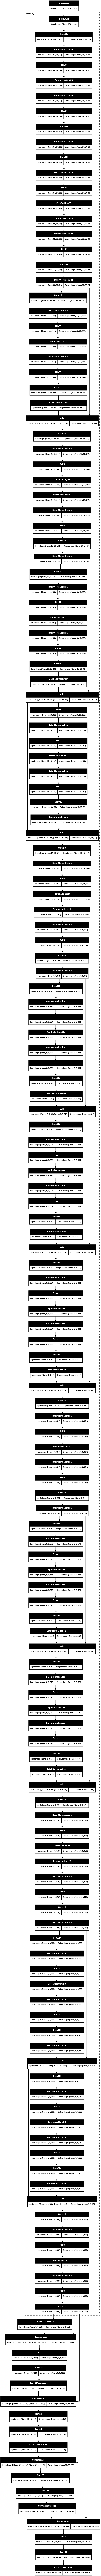

In [18]:
tf.keras.utils.plot_model(model,show_shapes=True,expand_nested=True,dpi=64)

In [20]:
def create_mask(pred_mask):
  pred_mask=tf.math.argmax(pred_mask,axis=-1)
  pred_mask=pred_mask[...,tf.newaxis]
  return pred_mask[0]

In [27]:
def show_predictions(dataset=None,num=1):
  if dataset:
    for image,mask in dataset.take(num):
      pred_mask=model.predict(image)
      display([image[0],mask[0],create_mask(pred_mask)])
  else:
    display([sample_image,sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis,...]))])


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


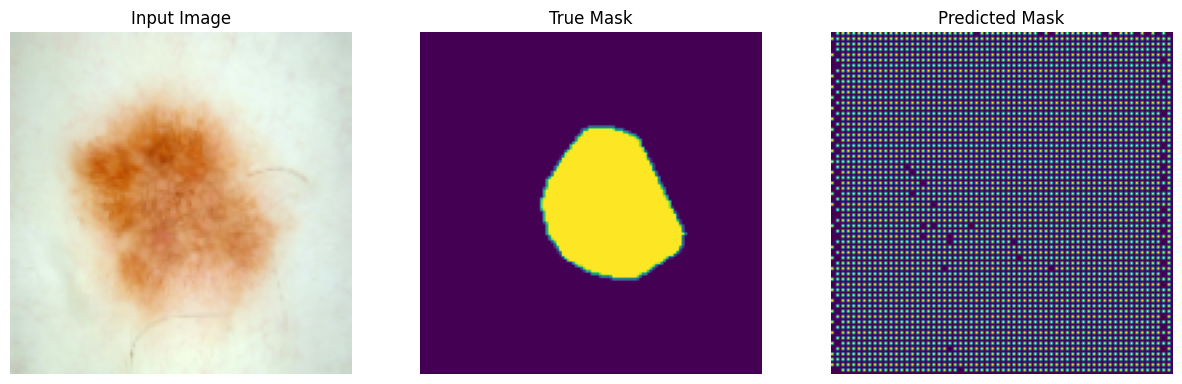

In [28]:
show_predictions()

In [29]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ [(None, 64, 64, 96),   │      1,841,984 │ input_layer_3[0][0]    │
│                           │ (None, 32, 32, 144),   │                │                        │
│                           │ (None, 16, 16, 192),   │                │                        │
│                           │ (None, 8, 8, 576),     │                │                        │
│                           │ (None, 4, 4, 320)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 8, 8, 512)      │        655,872 │ functional_2[0][4]     │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 8, 8, 1088)     │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ functional_2[0][3]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 8, 8, 512)      │      5,014,016 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 16, 16, 256)    │        524,544 │ conv2d_1[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 16, 16, 448)    │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ functional_2[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 256)    │      1,032,448 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 32, 32, 128)    │        131,200 │ conv2d_3[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 32, 32, 272)    │              0 │ conv2d_transpose_2[0]… │
│ (Concatenate)             │                        │                │ functional_2[0][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │        313,472 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_4[0][0]         │
├──────────────────────

 Total params: 12,773,122 (48.73 MB)

 Trainable params: 10,931,138 (41.70 MB)

 Non-trainable params: 1,841,984 (7.03 MB)

In [31]:
from keras import callbacks
EPOCHS=20
VAL_SUBSPLITS=5
num_valid_images=len(os.listdir("/content/valid_data"))
VALIDATION_STEPS=num_valid_images//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH=len(train_dataset)//BATCH_SIZE
valid_batch=valid_batch.repeat()


earlystopping=callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=5,
                                       restore_best_weights=True)
print("STEPS_PER_EPOCH :",STEPS_PER_EPOCH)
print("VALIDATION_STEPS :",VALIDATION_STEPS)
print("callbacks", earlystopping)
model_history=model.fit(train_batches,
                        epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_steps=VALIDATION_STEPS,
                        validation_data=valid_batch,
                        callbacks=[earlystopping],
                        verbose=1
                        )

STEPS_PER_EPOCH : 28
VALIDATION_STEPS : 1
callbacks <keras.src.callbacks.early_stopping.EarlyStopping object at 0x78bbf475df60>
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.7767 - loss: 0.5438 - val_accuracy: 0.6858 - val_loss: 0.6090
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - accuracy: 0.7689 - loss: 0.5417 - val_accuracy: 0.7935 - val_loss: 0.5378
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 561ms/step - accuracy: 0.7699 - loss: 0.5333 - val_accuracy: 0.7266 - val_loss: 0.5907
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step - accuracy: 0.7735 - loss: 0.5288 - val_accuracy: 0.8987 - val_loss: 0.4438
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 553ms/step - accuracy: 0.7832 - loss: 0.5116 - val_accuracy: 0.7989 - val_loss: 0.5337
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 703ms/step - accuracy: 0.7774 - loss: 0.5146 - val_accuracy: 0.7531 - val_loss: 0.5500
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 451ms/step - accuracy: 0.7878 - loss: 0.5121 - val_accura

# Evaluation

In [57]:
def plot_history(hist):
  fig,ax=plt.subplots(ncols=2,figsize=(12,10))
  ax[0].plot(hist.history['loss'])
  ax[0].plot(hist.history['val_loss'])
  ax[0].set_title("Loss evolution")
  ax[0].set_ylabel('loss')
  ax[0].set_xlabel('epoch')
  plt.legend(['train','validation'],loc='upper left')

  ax[1].plot(hist.history['accuracy'])
  ax[1].plot(hist.history['val_accuracy'])
  ax[1].set_title("Accuracy evolution")
  ax[1].set_ylabel('accuracy')
  ax[1].set_xlabel('epoch')
  plt.show()

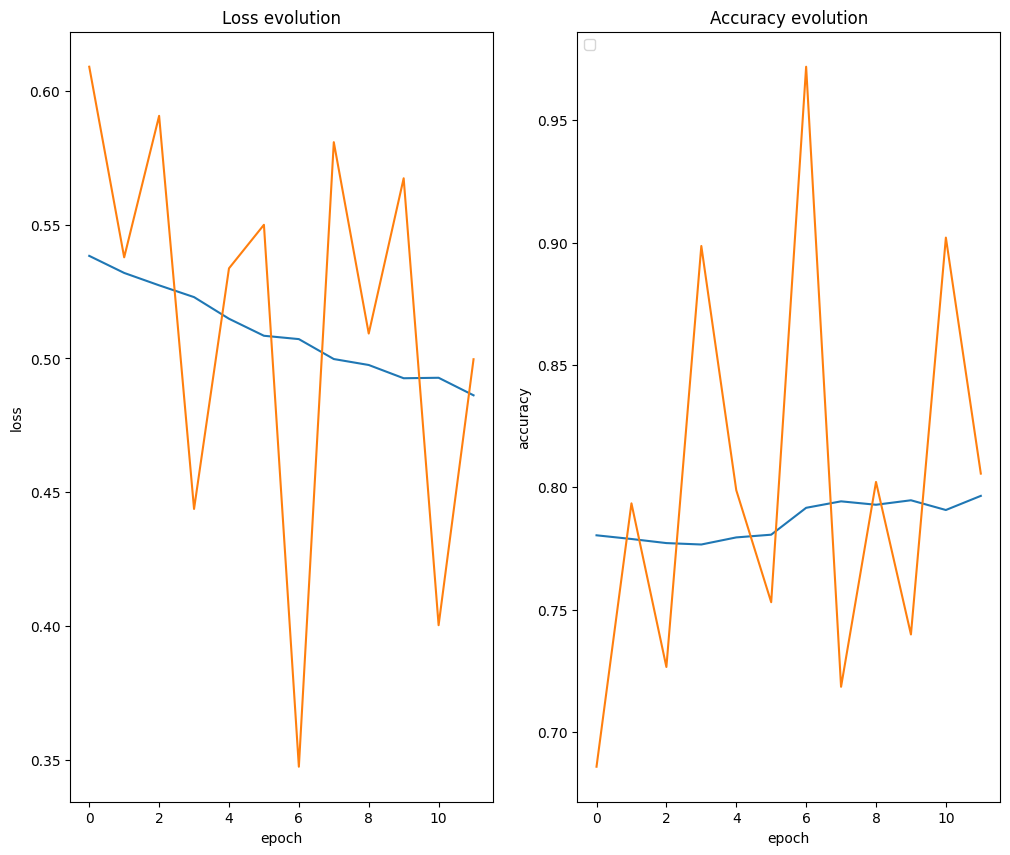

In [58]:
plot_history(model_history)

In [60]:
model.export("model.tflite")

Saved artifact at 'model.tflite'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_163')
Output Type:
  TensorSpec(shape=(None, 128, 128, 2), dtype=tf.float32, name=None)
Captures:
  132751324852320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132751324669984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132751324660480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132751324675616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132751324665584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132751324666288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132751324668400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132751324673680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132751324675440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132751324673152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1327

In [42]:
preds=model.predict(test_batches)

7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step


In [43]:
result=model.evaluate(test_batches)

7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.7795 - loss: 0.5337


In [65]:
loaded_model=tf.saved_model.load("/content/model.tflite/")
loaded_model

In [62]:
from google.colab import files
import shutil

shutil.make_archive("final_lite_model","zip","/content/model.tflite")
files.download("final_lite_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
None in test_batches

False